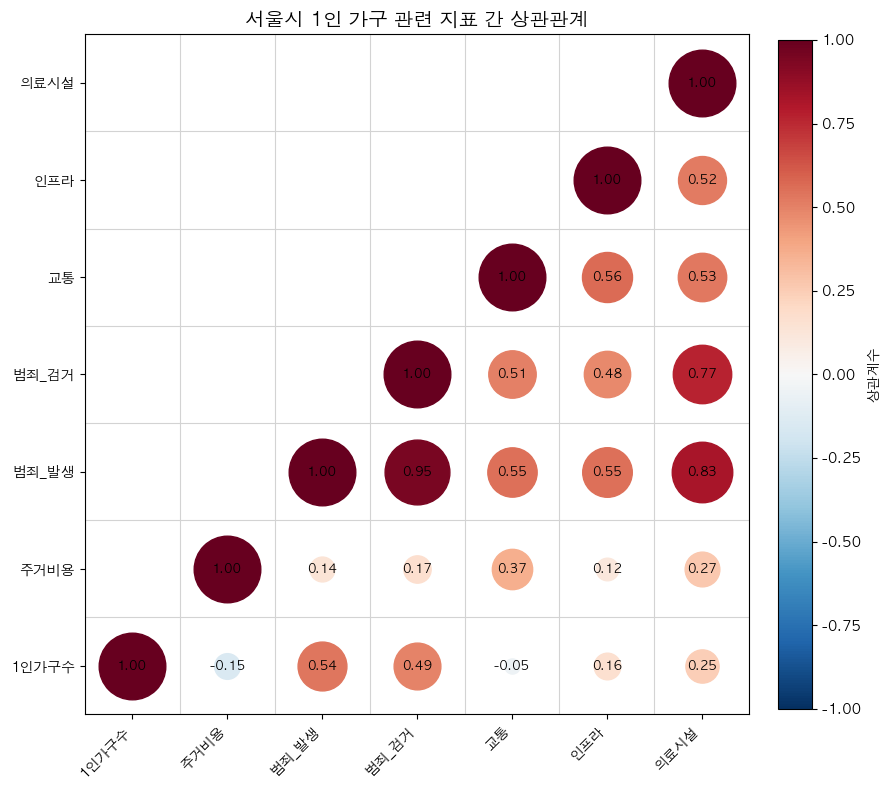


[설명분산/누적설명분산]
 PC   설명분산비율   누적설명분산
PC1 0.537050 0.537050
PC2 0.198942 0.735993
PC3 0.111992 0.847985
PC4 0.069583 0.917568
PC5 0.051976 0.969544
PC6 0.025218 0.994762
PC7 0.005238 1.000000

[성분분석표(loadings)]
            PC1       PC2       PC3       PC4       PC5       PC6       PC7
1인가구수 -0.226892  0.637319 -0.293025  0.528684  0.211406 -0.341015  0.126453
주거비용   0.148594  0.578393  0.693949 -0.365864  0.141379 -0.077046  0.045102
범죄_발생  0.491916 -0.176585  0.062648  0.161769 -0.044311 -0.186575  0.812385
범죄_검거 -0.472686  0.164998 -0.136697 -0.228435  0.076221  0.628719  0.526667
교통    -0.359627 -0.424729  0.251181  0.011329  0.742857 -0.260946  0.084403
인프라   -0.359137 -0.133998  0.583812  0.567059 -0.418521  0.119525  0.035022
의료시설  -0.450239 -0.050298 -0.077659 -0.431973 -0.447827 -0.604397  0.190469


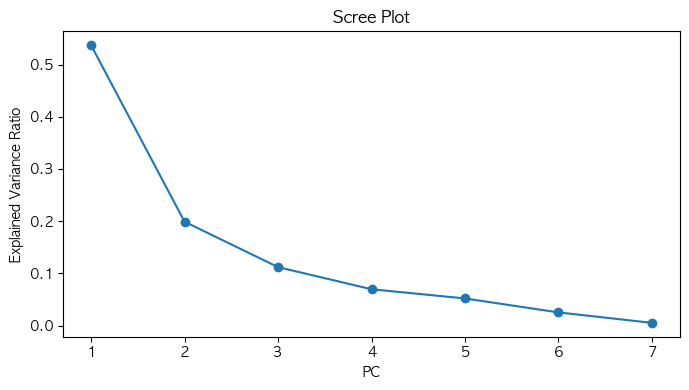

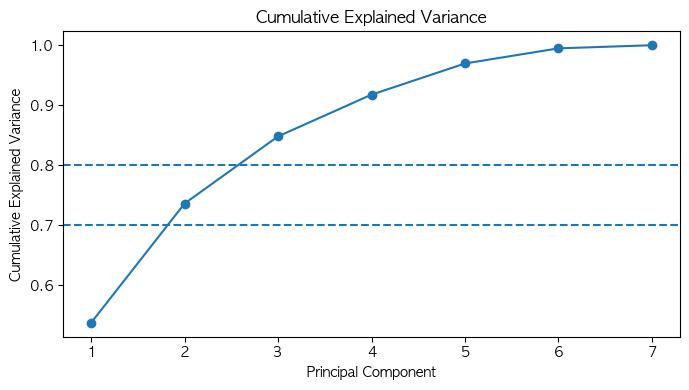

loading 시각화


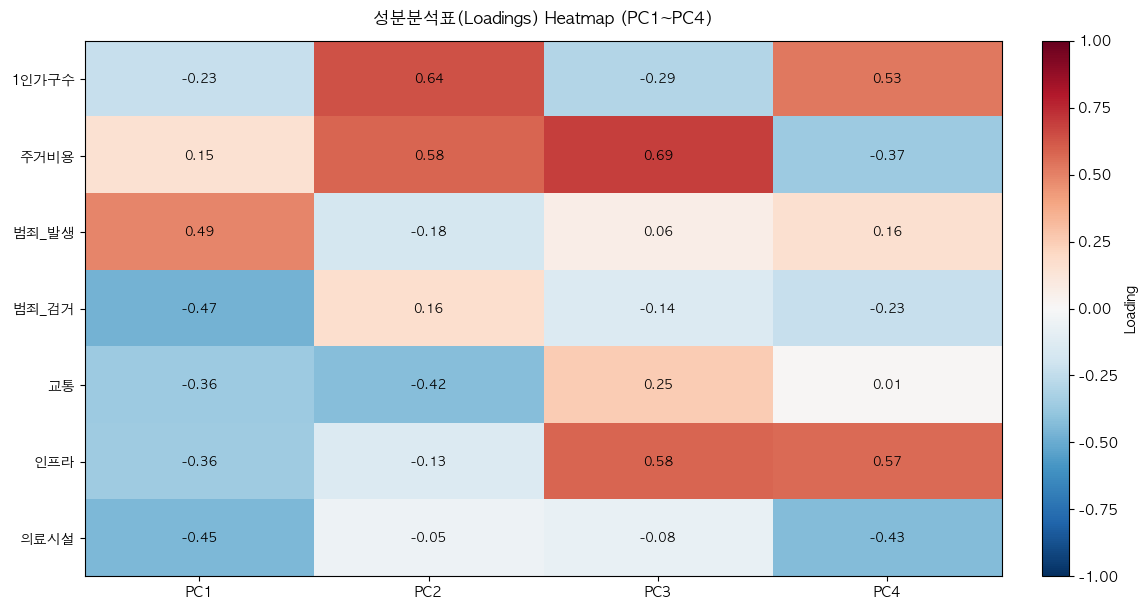

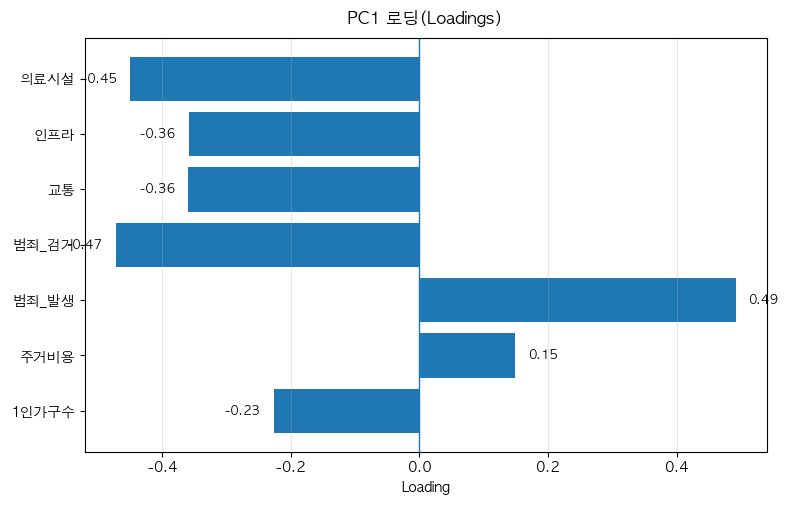

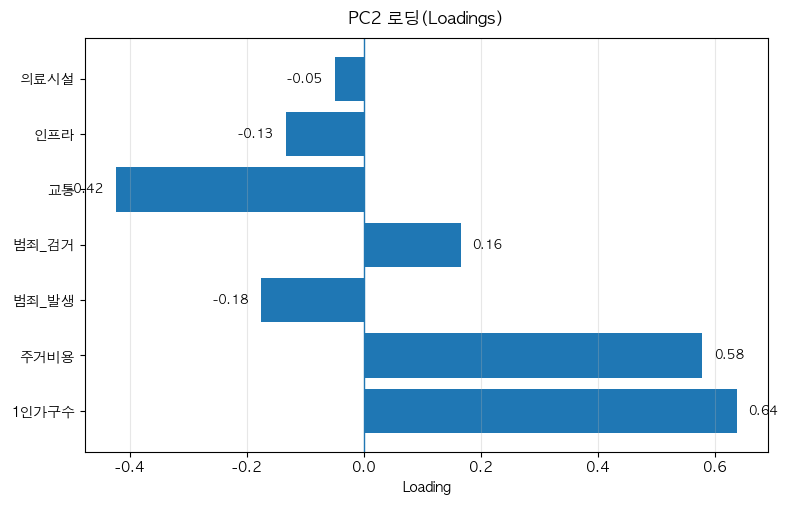

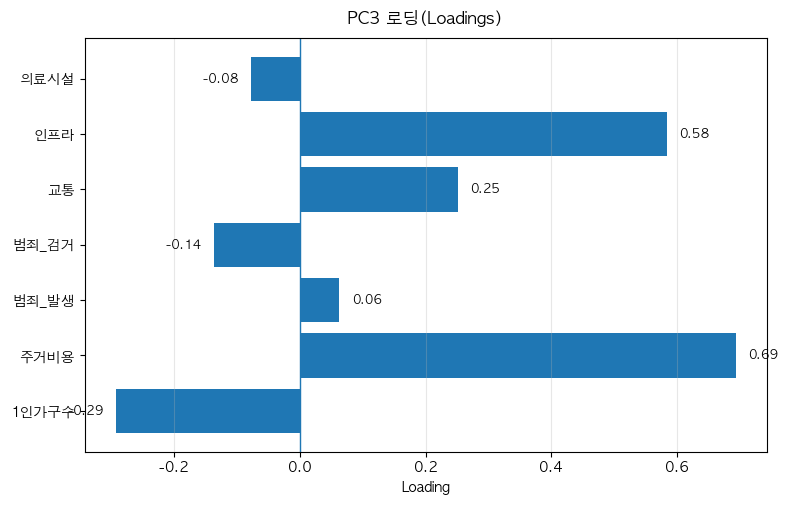

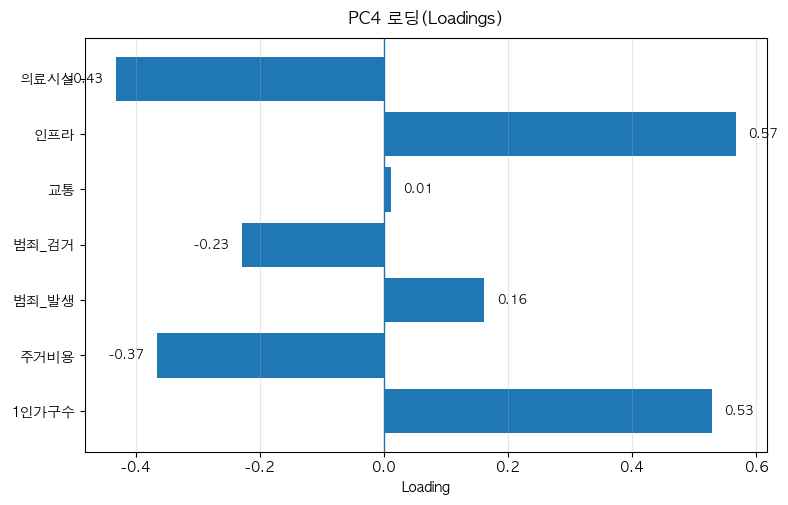

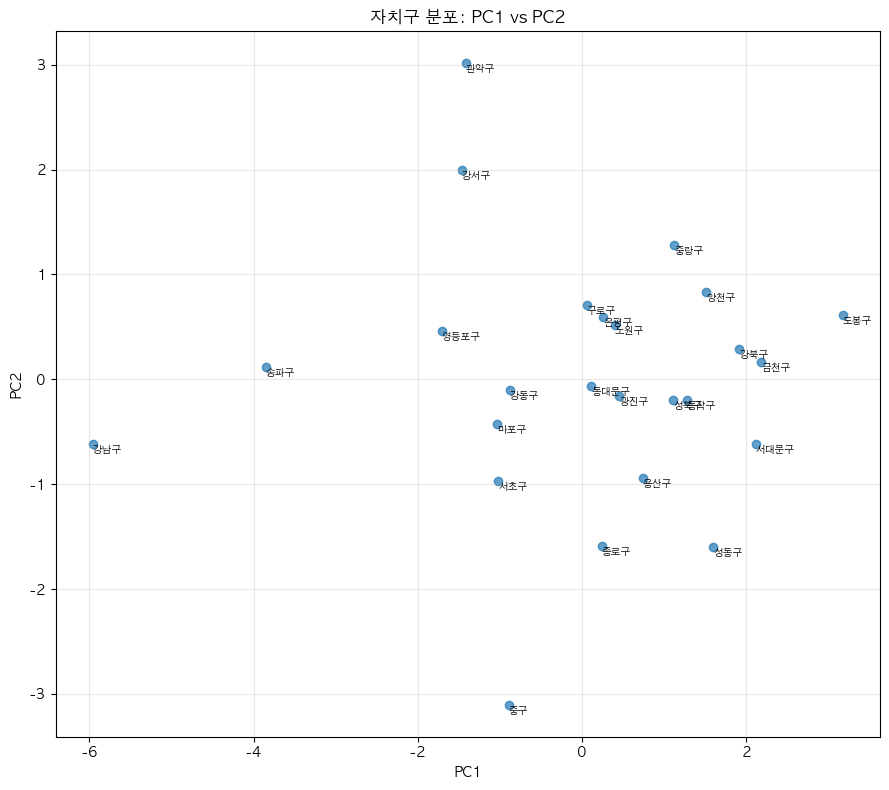


[PCA_자취적합지수 Top 10]
                 PC1       PC2       PC3       PC4  PCA_자취적합지수  PCA_순위  1인가구수
Unnamed: 0                                                                   
도봉구         3.170664  0.614067  0.729514 -0.896693    2.009961       1  43347
금천구         2.176401  0.161972 -0.184808 -0.062044    1.281699       2  53858
강북구         1.914603  0.290417 -0.065485 -0.196255    1.160704       3  53705
양천구         1.506171  0.832353  0.846758 -1.034289    1.086940       4  47886
서대문구        2.116864 -0.619138 -0.854610  0.442366    1.033996       5  56770
중랑구         1.120741  1.278187  0.170804 -0.951408    0.881795       6  69149
성북구         1.104918 -0.199859  0.357699  0.986441    0.721837       7  70230
동작구         1.271249 -0.194050 -0.694538  0.314852    0.641092       8  75148
성동구         1.598718 -1.594624 -0.930102  0.054911    0.480630       9  48442
노원구         0.396212  0.515010  0.686295 -0.399241    0.397052      10  67182

[MCDM(PC기준 엔트로피) 가중치]
평가기준      가중치    가중치

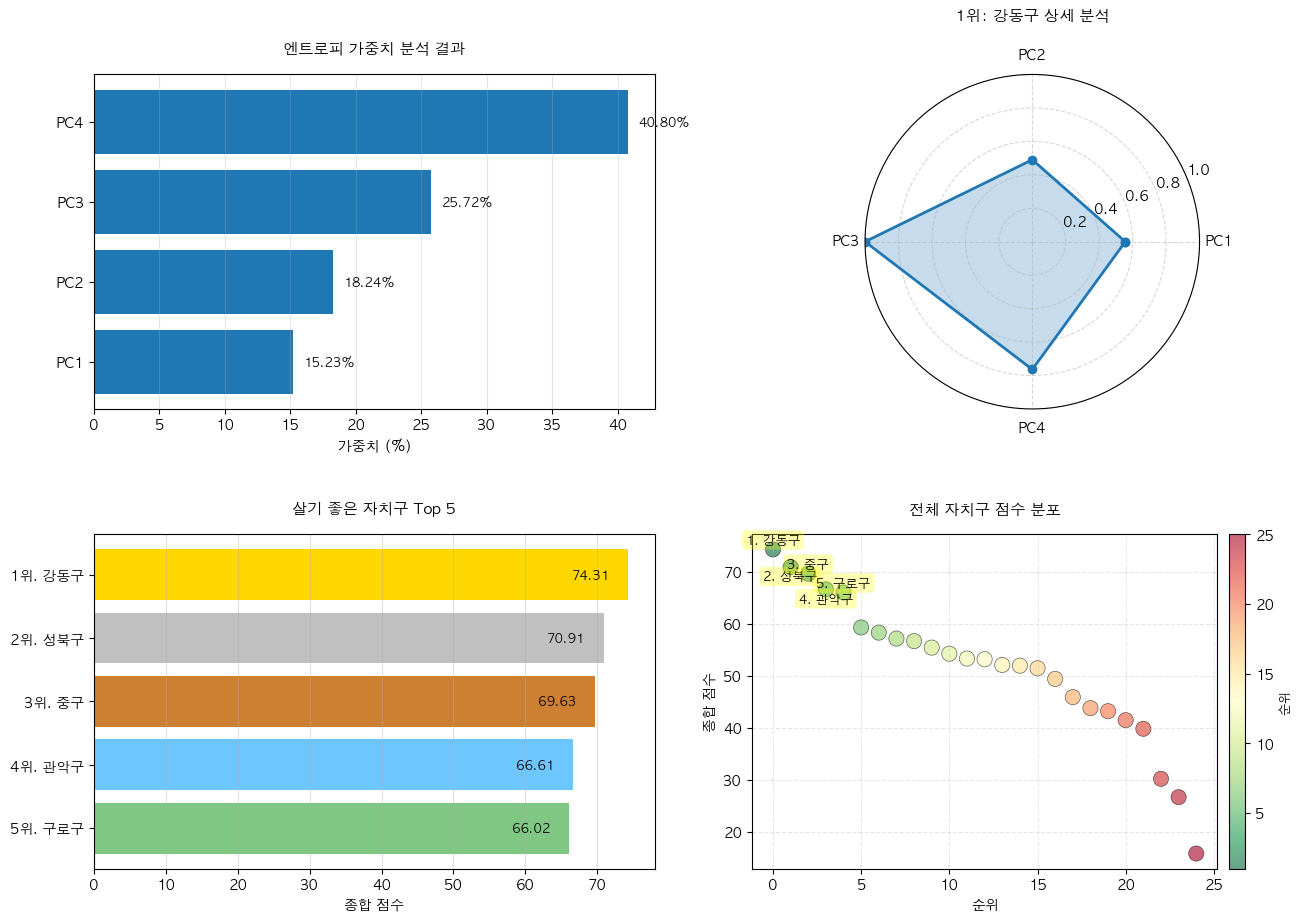

✅ 시각화 이미지 저장 완료: mcdm_analysis_results.png

✅ 엑셀 저장 완료: PCA_MCDM_통합결과_종합.xlsx


In [5]:
# =========================================
# PCA + MCDM(Entropy) 통합 분석 + 시각화 + 엑셀저장(스타일)
# =========================================

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from openpyxl import load_workbook
from openpyxl.styles import Font, PatternFill, Alignment, Border, Side


# -----------------------------------------
# 0) 한글 폰트 설정
# -----------------------------------------
font_candidates = [
    "NanumGothic",
    "Nanum Barun Gothic",
    "Malgun Gothic",
    "AppleGothic"
]
available_fonts = [f.name for f in fm.fontManager.ttflist]
for font in font_candidates:
    if font in available_fonts:
        plt.rcParams["font.family"] = font
        break
plt.rcParams["axes.unicode_minus"] = False


# -----------------------------------------
# 1) 엔트로피 가중치 계산
# (입력은 "정규화된 데이터"여야 함: 0~1 범위 권장)
# -----------------------------------------
def calculate_entropy_weights(data: np.ndarray, criteria: list[str]) -> np.ndarray:
    """
    data: shape (m, n) / m=대안(자치구), n=기준
    주의: data는 양수(0~1 권장), 합이 0인 열은 자동 보정
    """
    m, n = data.shape
    k = 1 / np.log(m)
    weights = []

    for j in range(n):
        column = data[:, j].astype(float)

        # 열합 0 방지 + log(0) 방지
        col_sum = np.sum(column)
        if col_sum == 0:
            column = np.full_like(column, 1e-10)
            col_sum = np.sum(column)

        p = column / col_sum
        p = np.where(p == 0, 1e-10, p)

        entropy = -k * np.sum(p * np.log(p))
        diversity = 1 - entropy
        weights.append(diversity)

    weights = np.array(weights)
    if weights.sum() == 0:
        weights = np.ones(n) / n
    else:
        weights = weights / np.sum(weights)

    return weights


# -----------------------------------------
# 2) 엑셀 저장 + 스타일 적용
# -----------------------------------------
def apply_excel_styles(file_path: str):
    wb = load_workbook(file_path)

    header_fill = PatternFill(start_color="4472C4", end_color="4472C4", fill_type="solid")
    header_font = Font(bold=True, color="FFFFFF", size=11)
    header_alignment = Alignment(horizontal="center", vertical="center")

    thin_border = Border(
        left=Side(style="thin"),
        right=Side(style="thin"),
        top=Side(style="thin"),
        bottom=Side(style="thin")
    )

    for sheet_name in wb.sheetnames:
        ws = wb[sheet_name]

        # header
        for cell in ws[1]:
            cell.fill = header_fill
            cell.font = header_font
            cell.alignment = header_alignment
            cell.border = thin_border

        # body
        for row in ws.iter_rows(min_row=2, max_row=ws.max_row, max_col=ws.max_column):
            for cell in row:
                cell.alignment = Alignment(horizontal="center", vertical="center")
                cell.border = thin_border

        # highlight
        if sheet_name == "Top5":
            gold_fill = PatternFill(start_color="FFD700", end_color="FFD700", fill_type="solid")
            # 2번째 행(1위)만 강조
            if ws.max_row >= 2:
                for cell in ws[2]:
                    cell.fill = gold_fill

        if sheet_name == "Bottom5":
            red_fill = PatternFill(start_color="FFB6C1", end_color="FFB6C1", fill_type="solid")
            # 마지막 행(꼴찌)만 강조
            if ws.max_row >= 2:
                for cell in ws[ws.max_row]:
                    cell.fill = red_fill

        # column width
        for column in ws.columns:
            max_length = 0
            column_letter = column[0].column_letter
            for cell in column:
                try:
                    max_length = max(max_length, len(str(cell.value)))
                except Exception:
                    pass
            ws.column_dimensions[column_letter].width = min(max_length + 2, 20)

    wb.save(file_path)


def export_to_excel_with_style(results_df: pd.DataFrame,
                               weights: np.ndarray,
                               final_criteria: list[str],
                               district_col: str,
                               weight_df: pd.DataFrame,
                               output_file: str = "PCA_MCDM_통합결과_종합.xlsx") -> str:
    """
    결과를 보기 좋게 스타일 적용된 엑셀로 저장
    포함:
      - 전체순위
      - Top5
      - Bottom5
      - 가중치
      - 통계요약
    """
    with pd.ExcelWriter(output_file, engine="openpyxl") as writer:
        # 전체순위
        output_columns = [district_col] + final_criteria + ["종합점수", "순위"]
        display_df = results_df[output_columns].copy()

        # 0~1 -> 0~100 변환(보기 좋게)
        for c in final_criteria:
            display_df[c] = display_df[c] * 100

        display_df.to_excel(writer, sheet_name="전체순위", index=False)

        # Top5 / Bottom5
        display_df.head(5).to_excel(writer, sheet_name="Top5", index=False)
        display_df.tail(5).to_excel(writer, sheet_name="Bottom5", index=False)

        # 가중치
        weight_df.to_excel(writer, sheet_name="가중치", index=False)

        # 통계요약
        stats_data = []
        for criterion in final_criteria + ["종합점수"]:
            if criterion in display_df.columns:
                stats_data.append({
                    "평가기준": criterion,
                    "평균": float(display_df[criterion].mean()),
                    "최댓값": float(display_df[criterion].max()),
                    "최솟값": float(display_df[criterion].min()),
                    "표준편차": float(display_df[criterion].std())
                })
        pd.DataFrame(stats_data).to_excel(writer, sheet_name="통계요약", index=False)

    apply_excel_styles(output_file)
    print(f"\n✅ 엑셀 저장 완료: {output_file}")
    return output_file


# -----------------------------------------
# 3) MCDM 시각화 (너 코드 스타일 유지)
# -----------------------------------------
def visualize_results(results_df: pd.DataFrame,
                      weights: np.ndarray,
                      criteria: list[str],
                      district_col: str,
                      out_png: str = "mcdm_analysis_results.png"):
    """
    4개 차트:
      1) 가중치 바차트
      2) Top5 바차트
      3) 1위 레이더
      4) 전체 점수 분포
    """
    fig = plt.figure(figsize=(14, 10))

    # 1) 가중치 바차트
    ax1 = plt.subplot(2, 2, 1)
    weight_df = pd.DataFrame({"기준": criteria, "가중치": weights * 100})
    bars = ax1.barh(weight_df["기준"], weight_df["가중치"])
    ax1.set_xlabel("가중치 (%)", fontsize=10)
    ax1.set_title("엔트로피 가중치 분석 결과", fontsize=11, fontweight="bold", pad=15)
    ax1.grid(axis="x", alpha=0.3)

    for bar in bars:
        w = bar.get_width()
        ax1.text(w + 0.8, bar.get_y() + bar.get_height()/2,
                 f"{w:.2f}%", ha="left", va="center", fontsize=9)

    # 2) Top5 바차트
    ax2 = plt.subplot(2, 2, 3)
    top5 = results_df.head(5)

   # 🎨 순위별 색상 (1~5위)
    colors = ['#FFD700',  # Gold
            '#C0C0C0',  # Silver
            '#CD7F32',  # Bronze
            '#6EC6FF',  # Light Blue
            '#81C784']  # Light Green

    bars2 = ax2.barh(
      range(len(top5)),
      top5["종합점수"].values,
      color=colors
     )

    ax2.set_yticks(range(len(top5)))
    ax2.set_yticklabels(
      [f"{i+1}위. {name}" for i, name in enumerate(top5[district_col].values)],
      fontsize=10
    )
    ax2.set_xlabel("종합 점수", fontsize=10)
    ax2.set_title("살기 좋은 자치구 Top 5", fontsize=11, fontweight="bold", pad=15)
    ax2.invert_yaxis()
    ax2.grid(axis="x", alpha=0.4)

    # 점수 라벨
    for i, bar in enumerate(bars2):
      w = bar.get_width()
      ax2.text(
         w - 2.5,
         bar.get_y() + bar.get_height() / 2,
         f"{w:.2f}",
         ha="right",
         va="center",
         fontsize=9,
         fontweight="bold",
         color="black"  # 밝은 색이라 검정이 더 잘 보임
      )

    # 3) 레이더 차트 (1위)
    ax3 = plt.subplot(2, 2, 2, projection="polar")
    top1 = results_df.iloc[0]

    # criteria 값은 0~1로 되어 있어야 레이더가 깔끔함
    vals = [float(top1[c]) for c in criteria]
    angles = np.linspace(0, 2*np.pi, len(criteria), endpoint=False).tolist()
    vals += vals[:1]
    angles += angles[:1]

    ax3.plot(angles, vals, "o-", linewidth=2, markersize=6)
    ax3.fill(angles, vals, alpha=0.25)
    ax3.set_xticks(angles[:-1])
    ax3.set_xticklabels(criteria, fontsize=10)
    ax3.set_ylim(0, 1.0)
    ax3.set_title(f"1위: {top1[district_col]} 상세 분석", fontsize=11, fontweight="bold", pad=20)
    ax3.grid(True, linestyle="--", alpha=0.5)

    # 4) 전체 점수 분포
    ax4 = plt.subplot(2, 2, 4)
    scatter = ax4.scatter(range(len(results_df)),
                          results_df["종합점수"].values,
                          c=results_df["순위"].values,
                          cmap="RdYlGn_r",
                          s=120,
                          alpha=0.6,
                          edgecolors="black",
                          linewidths=0.5)
    ax4.set_xlabel("순위", fontsize=10)
    ax4.set_ylabel("종합 점수", fontsize=10)
    ax4.set_title("전체 자치구 점수 분포", fontsize=11, fontweight="bold", pad=15)
    ax4.grid(True, alpha=0.3, linestyle="--")

    # 상위 5개 라벨링
    for i in range(min(5, len(results_df))):
        x = i
        y = results_df.iloc[i]["종합점수"]
        name = results_df.iloc[i][district_col]
        y_offset = 2.5 if i % 2 == 0 else -2.5
        va = "bottom" if i % 2 == 0 else "top"
        ax4.annotate(f"{i+1}. {name}", (x, y),
                     xytext=(0, y_offset), textcoords="offset points",
                     ha="center", va=va, fontsize=9, fontweight="bold",
                     bbox=dict(boxstyle="round,pad=0.3", facecolor="yellow", alpha=0.3, edgecolor="none"))

    cbar = plt.colorbar(scatter, ax=ax4, pad=0.02)
    cbar.set_label("순위", fontsize=9)

    plt.tight_layout(pad=3.5)
    plt.savefig(out_png, dpi=300, bbox_inches="tight")
    plt.show()
    print(f"✅ 시각화 이미지 저장 완료: {out_png}")


# -----------------------------------------
# 4) 상관관계 버블 차트 (너 PCA 코드 버전)
# -----------------------------------------
def plot_corr_bubble(selected_clean: pd.DataFrame, label_map: dict):
    corr = selected_clean.corr()
    corr_plot = corr.rename(index=label_map, columns=label_map)

    plt.figure(figsize=(9, 8))
    ax = plt.gca()
    n = len(corr_plot.columns)

    for i in range(n):
        for j in range(i + 1):
            v = corr_plot.iloc[i, j]
            ax.scatter(i, j, s=abs(v) * 2300, c=v, cmap="RdBu_r", vmin=-1, vmax=1)
            ax.text(i, j, f"{v:.2f}", ha="center", va="center", fontsize=9)

    ax.set_xticks(range(n))
    ax.set_yticks(range(n))
    ax.set_xticklabels(corr_plot.columns, rotation=45, ha="right")
    ax.set_yticklabels(corr_plot.columns)

    ax.set_xticks(np.arange(-0.5, n, 1), minor=True)
    ax.set_yticks(np.arange(-0.5, n, 1), minor=True)
    ax.grid(which="minor", color="lightgray", linestyle="-", linewidth=0.8)
    ax.tick_params(which="minor", bottom=False, left=False)

    plt.title("서울시 1인 가구 관련 지표 간 상관관계", fontsize=14)
    sm = plt.cm.ScalarMappable(cmap="RdBu_r", norm=plt.Normalize(-1, 1))
    sm.set_array([])
    plt.colorbar(sm, ax=ax, fraction=0.046, pad=0.04, label="상관계수")

    plt.tight_layout()
    plt.show()

def plot_loadings_heatmap(loadings: pd.DataFrame, n_pc: int = 4, title: str = "성분분석표(Loadings) Heatmap"):
    """
    loadings: index=features, columns=PC1..PCk
    n_pc: 보여줄 주성분 개수
    """
    L = loadings.iloc[:, :n_pc].copy()

    fig, ax = plt.subplots(figsize=(1.4*n_pc + 6, 0.6*len(L) + 2))
    im = ax.imshow(L.values, aspect="auto", cmap="RdBu_r", vmin=-1, vmax=1)

    # 축 라벨
    ax.set_xticks(np.arange(L.shape[1]))
    ax.set_xticklabels(L.columns, fontsize=10)
    ax.set_yticks(np.arange(L.shape[0]))
    ax.set_yticklabels(L.index, fontsize=10)

    # 값 표시(annot)
    for i in range(L.shape[0]):
        for j in range(L.shape[1]):
            v = L.values[i, j]
            ax.text(j, i, f"{v:.2f}", ha="center", va="center", fontsize=9)

    ax.set_title(title, fontsize=12, fontweight="bold", pad=12)
    ax.grid(False)

    cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    cbar.set_label("Loading", fontsize=10)

    plt.tight_layout()
    plt.show()



def plot_loadings_bars(loadings: pd.DataFrame, n_pc: int = 4, top_k: int = None):
    """
    PC별 로딩 bar plot.
    top_k: None이면 전체 변수, 숫자면 |loading| 큰 변수 top_k만 표시
    """
    L = loadings.iloc[:, :n_pc].copy()

    for pc in L.columns:
        s = L[pc].copy()
        if top_k is not None:
            s = s.reindex(s.abs().sort_values(ascending=False).index[:top_k])

        fig, ax = plt.subplots(figsize=(8, 0.45*len(s) + 2))
        bars = ax.barh(s.index, s.values)
        ax.axvline(0, linewidth=1)
        ax.set_title(f"{pc} 로딩(Loadings)", fontsize=12, fontweight="bold", pad=10)
        ax.set_xlabel("Loading", fontsize=10)
        ax.grid(axis="x", alpha=0.3)

        # 값 표시
        for b in bars:
            w = b.get_width()
            ax.text(w + (0.02 if w >= 0 else -0.02),
                    b.get_y() + b.get_height()/2,
                    f"{w:.2f}",
                    ha="left" if w >= 0 else "right",
                    va="center",
                    fontsize=9)

        plt.tight_layout()
        plt.show()


# -----------------------------------------
# 5) 메인 실행
# -----------------------------------------
def main():
    # ========== (A) 데이터 로드 & 전처리 ==========
    file_path = "서울시 1인가구수 (1).xlsx"  # 너 파일로 맞춰서 수정 가능
    df = pd.read_excel(file_path)

    data = df.iloc[4:, :].copy()
    data = data.rename(columns={
        data.columns[1]:  "1인가구수",
        data.columns[10]: "주거비용",
        data.columns[11]: "범죄_발생",
        data.columns[12]: "범죄_검거",
        data.columns[15]: "교통",
        data.columns[16]: "인프라",
        data.columns[19]: "의료시설"
    })


    data = data.set_index(data.columns[0])

    selected = data[
        ["1인가구수", "주거비용", "범죄_발생", "범죄_검거", "교통", "인프라", "의료시설"]
    ].apply(pd.to_numeric, errors="coerce")

    selected_clean = selected.dropna().copy()

    # 상관관계 그래프용 라벨
    label_map = {
        "1인가구수": "1인가구수",
        "인프라": "인프라",
        "주거비용": "주거비용",
        "교통": "교통",
        "의료시설": "의료시설",
        "범죄_발생": "범죄_발생",
        "범죄_검거": "범죄_검거"
    }

    # 상관관계 버블 차트
    plot_corr_bubble(selected_clean, label_map)

    # ========== (B) PCA ==========
    features = ["1인가구수","주거비용", "범죄_발생", "범죄_검거", "교통", "인프라", "의료시설"]
    X = selected_clean[features].copy()

    # 방향 통일(클수록 좋음)
    X["주거비용"] *= -1
    X["범죄_발생"] *= -1

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    pca = PCA()
    X_pca = pca.fit_transform(X_scaled)

    explained = pca.explained_variance_ratio_
    cumulative = np.cumsum(explained)

    explained_df = pd.DataFrame({
        "PC": [f"PC{i+1}" for i in range(len(explained))],
        "설명분산비율": explained,
        "누적설명분산": cumulative
    })

    print("\n[설명분산/누적설명분산]")
    print(explained_df.to_string(index=False))

    loadings = pd.DataFrame(
        pca.components_.T,
        index=features,
        columns=[f"PC{i+1}" for i in range(len(features))]
    )
    print("\n[성분분석표(loadings)]")
    print(loadings)

    # scree plot
    plt.figure(figsize=(7, 4))
    plt.plot(range(1, len(explained) + 1), explained, marker="o")
    plt.xticks(range(1, len(explained) + 1))
    plt.xlabel("PC")
    plt.ylabel("Explained Variance Ratio")
    plt.title("Scree Plot")
    plt.tight_layout()
    plt.show()

    # cumulative
    plt.figure(figsize=(7, 4))
    plt.plot(range(1, len(cumulative) + 1), cumulative, marker="o")
    plt.xticks(range(1, len(cumulative) + 1))
    plt.xlabel("Principal Component")
    plt.ylabel("Cumulative Explained Variance")
    plt.title("Cumulative Explained Variance")
    plt.axhline(0.7, linestyle="--")
    plt.axhline(0.8, linestyle="--")
    plt.tight_layout()
    plt.show()

    # ========== (C) PC 점수 생성 ==========
    n_pc = 4
    scores = pd.DataFrame(
        X_pca[:, :n_pc],
        index=selected_clean.index,
        columns=[f"PC{i+1}" for i in range(n_pc)]
    )
    scores["1인가구수"] = selected_clean["1인가구수"]
   
    print("loading 시각화")
    # ===== loadings 시각화 =====
    plot_loadings_heatmap(loadings, n_pc=n_pc, title="성분분석표(Loadings) Heatmap (PC1~PC4)")
    plot_loadings_bars(loadings, n_pc=n_pc, top_k=None)      # 전체 변수
    # plot_loadings_bars(loadings, n_pc=n_pc, top_k=4)       # |loading| 큰 변수 t_

    # PC1 vs PC2 산점도
    if n_pc >= 2:
        plt.figure(figsize=(9, 8))
        plt.scatter(scores["PC1"], scores["PC2"], alpha=0.7)

        for gu in scores.index:
            plt.text(scores.loc[gu, "PC1"], scores.loc[gu, "PC2"], gu,
                     fontsize=7, ha="left", va="top")

        plt.xlabel("PC1")
        plt.ylabel("PC2")
        plt.title("자치구 분포: PC1 vs PC2")
        plt.grid(alpha=0.3)
        plt.tight_layout()
        plt.show()

    # ========== (D) PCA 가중합 지수 (설명분산 기반) ==========
    pca_weights = explained[:n_pc]
    pca_weights = pca_weights / pca_weights.sum()

    scores["PCA_자취적합지수"] = 0.0
    for i in range(n_pc):
        scores["PCA_자취적합지수"] += pca_weights[i] * scores[f"PC{i+1}"]
    scores["PCA_순위"] = scores["PCA_자취적합지수"].rank(ascending=False, method="min").astype(int)

    print("\n[PCA_자취적합지수 Top 10]")
    print(scores.sort_values("PCA_순위").head(10)[[f"PC{i+1}" for i in range(n_pc)] + ["PCA_자취적합지수", "PCA_순위", "1인가구수"]])

    # ========== (E) PCA → MCDM(엔트로피) 연결 ==========
    pc_cols = [f"PC{i+1}" for i in range(n_pc)]
    pc_df = scores[pc_cols].copy()

    # 필요하면 PC 방향 뒤집기(해석 통일)
    #pc_df["PC2"] *= -1

    # 0~1 정규화
    den = (pc_df.max() - pc_df.min()).replace(0, np.nan)
    pc_norm = (pc_df - pc_df.min()) / den
    pc_norm = pc_norm.fillna(0.5)

    # 엔트로피 가중치
    mcdm_weights = calculate_entropy_weights(pc_norm.values, pc_cols)

    # 종합점수/순위
    scores["종합점수"] = np.dot(pc_norm.values, mcdm_weights) * 100
    scores["순위"] = scores["종합점수"].rank(ascending=False, method="min").astype(int)

    # 자치구 컬럼명 통일
    district_col = "자치구별"   # ← 너 파일/발표에서 쓰고 싶은 이름으로 통일

    results_df = scores.copy()
    results_df = results_df.reset_index()
    results_df = results_df.rename(columns={results_df.columns[0]: district_col})  # ✅ 무조건 첫 컬럼을 자치구별로
    results_df = results_df.sort_values("순위")


    # criteria는 (레이더/가중치) 표시용으로 PC를 쓰는 버전
    final_criteria = pc_cols

    # 가중치 DF
    weight_df = pd.DataFrame({
        "평가기준": final_criteria,
        "가중치": mcdm_weights,
        "가중치(%)": mcdm_weights * 100
    })

    print("\n[MCDM(PC기준 엔트로피) 가중치]")
    print(weight_df.to_string(index=False))

    print("\n[MCDM(PC기준 엔트로피) Top 10]")
    print(results_df.head(10)[[district_col] + final_criteria + ["종합점수", "순위"]])

    # 상관/순위 일치도
    corr_pca = scores["PCA_자취적합지수"].corr(scores["1인가구수"])
    corr_mcdm = scores["종합점수"].corr(scores["1인가구수"])
    spearman_rank = scores["PCA_순위"].corr(scores["순위"], method="spearman")
    print(f"\n[상관계수] PCA_자취적합지수 vs 1인가구수: {corr_pca:.4f}")
    print(f"[상관계수] MCDM 종합점수 vs 1인가구수: {corr_mcdm:.4f}")
    print(f"[순위 일치도(Spearman)] PCA_순위 vs MCDM_순위: {spearman_rank:.4f}")

    # ========== (F) MCDM 시각화 ==========
    # 레이더는 0~1 값이 보기 좋아서, results_df에 PC 정규화 값을 같이 넣어 사용
    norm_df = pc_norm.copy()
    norm_df["종합점수"] = scores["종합점수"]
    norm_df["순위"] = scores["순위"]
    norm_df = norm_df.reset_index()
    norm_df = norm_df.rename(columns={norm_df.columns[0]: district_col})  # ✅ 여기!
    norm_df = norm_df.sort_values("순위")


    visualize_results(
        results_df=norm_df.rename(columns={"종합점수": "종합점수", "순위": "순위"}),
        weights=mcdm_weights,
        criteria=final_criteria,
        district_col=district_col,
        out_png="mcdm_analysis_results.png"
    )

    # ========== (G) 엑셀 저장 ==========
    # 엑셀에는 이해 쉬우라고 PC 정규화 점수(0~1) + 종합점수 + 순위 저장
    export_to_excel_with_style(
        results_df=norm_df.rename(columns={"종합점수": "종합점수", "순위": "순위"}),
        weights=mcdm_weights,
        final_criteria=final_criteria,
        district_col=district_col,
        weight_df=weight_df,
        output_file="PCA_MCDM_통합결과_종합.xlsx"
    )

    return results_df, weight_df


if __name__ == "__main__":
    results_df, weight_df = main()


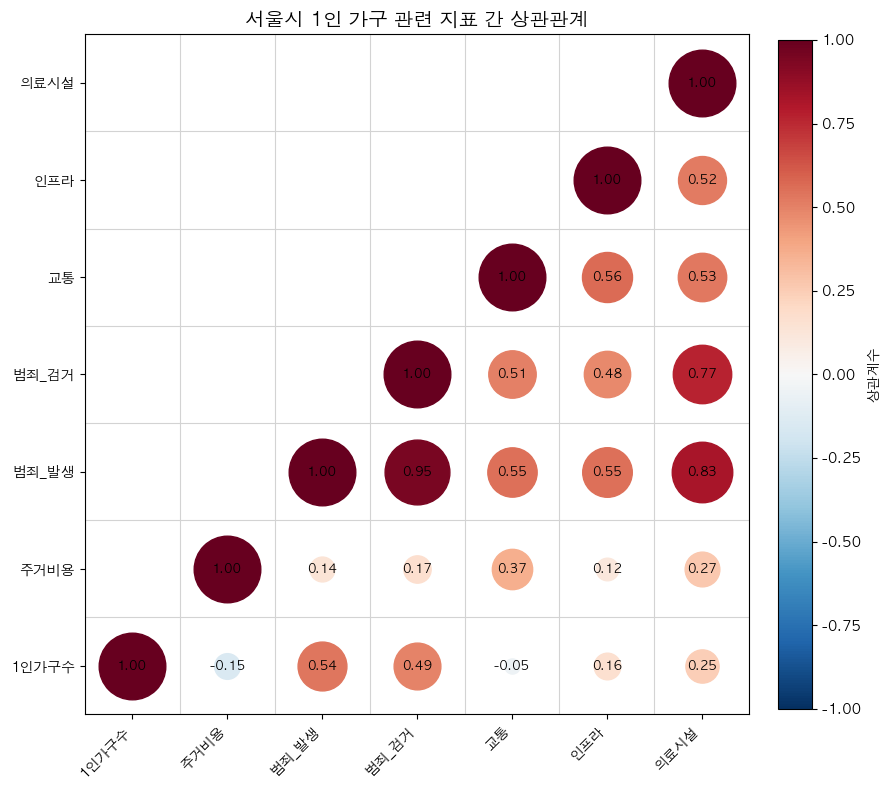


[설명분산/누적설명분산]
 PC   설명분산비율   누적설명분산
PC1 0.537050 0.537050
PC2 0.198942 0.735993
PC3 0.111992 0.847985
PC4 0.069583 0.917568
PC5 0.051976 0.969544
PC6 0.025218 0.994762
PC7 0.005238 1.000000

[성분분석표(loadings)]
            PC1       PC2       PC3       PC4       PC5       PC6       PC7
1인가구수 -0.226892  0.637319 -0.293025  0.528684  0.211406 -0.341015  0.126453
주거비용   0.148594  0.578393  0.693949 -0.365864  0.141379 -0.077046  0.045102
범죄_발생  0.491916 -0.176585  0.062648  0.161769 -0.044311 -0.186575  0.812385
범죄_검거 -0.472686  0.164998 -0.136697 -0.228435  0.076221  0.628719  0.526667
교통    -0.359627 -0.424729  0.251181  0.011329  0.742857 -0.260946  0.084403
인프라   -0.359137 -0.133998  0.583812  0.567059 -0.418521  0.119525  0.035022
의료시설  -0.450239 -0.050298 -0.077659 -0.431973 -0.447827 -0.604397  0.190469


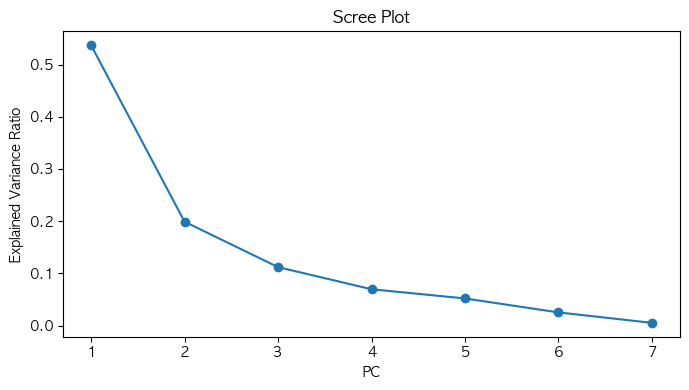

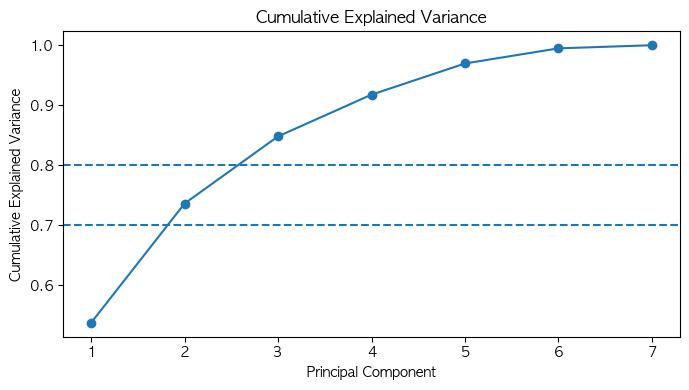

loading 시각화


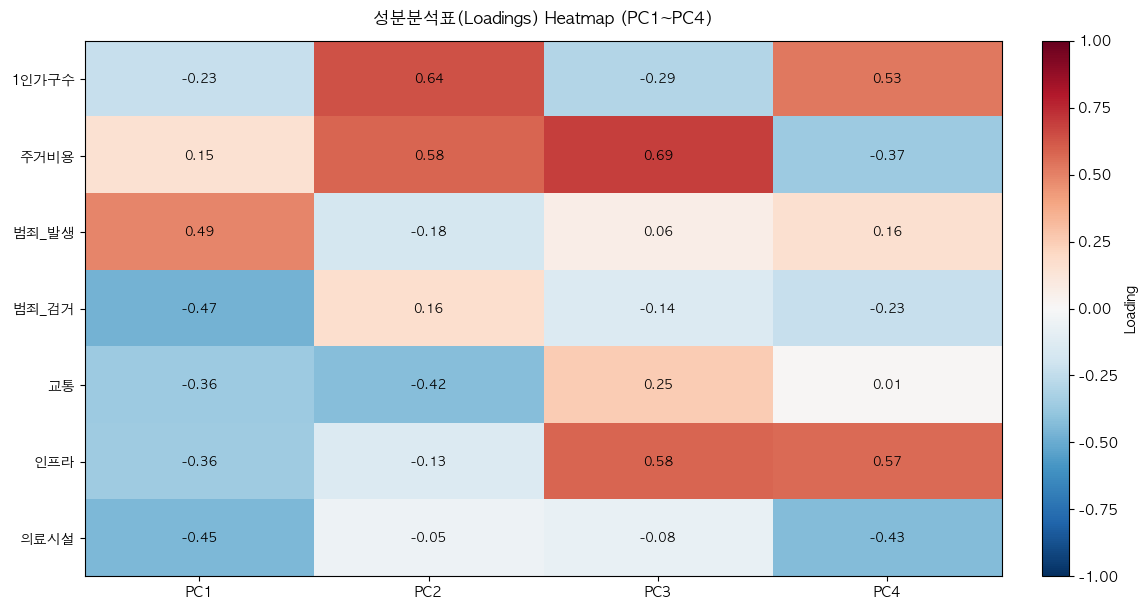

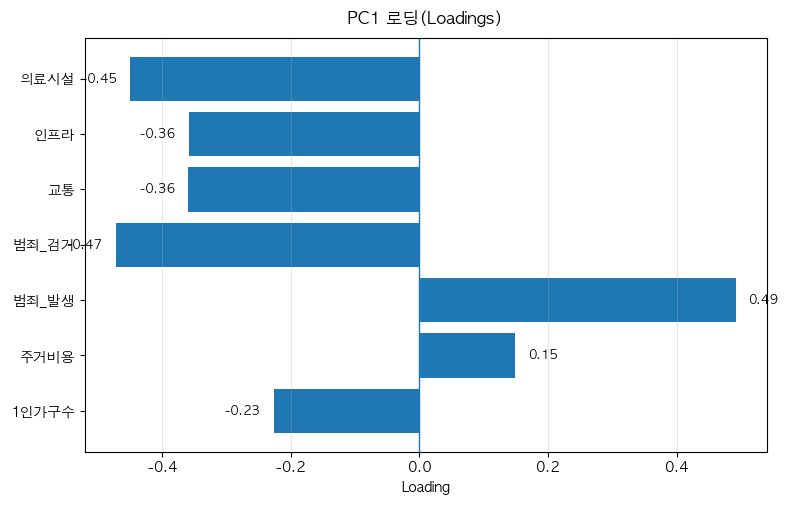

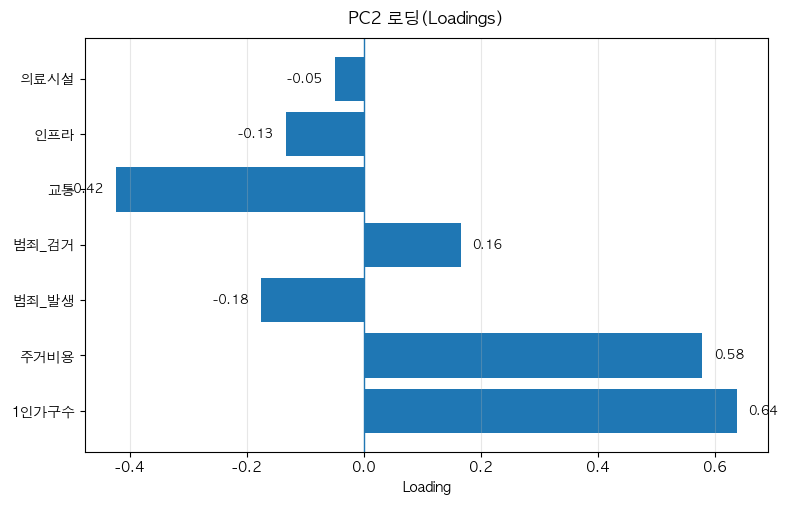

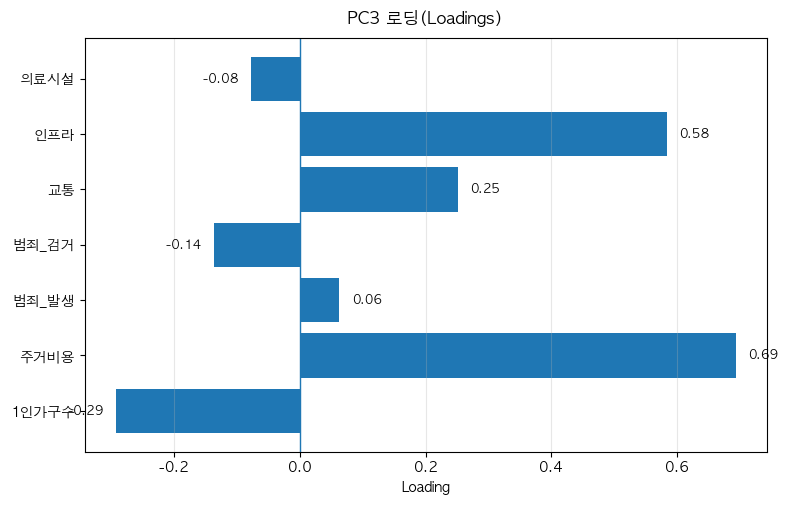

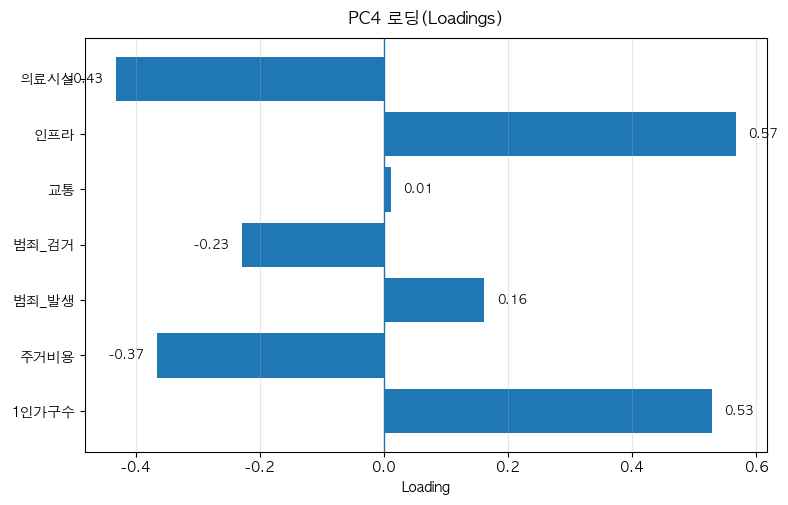

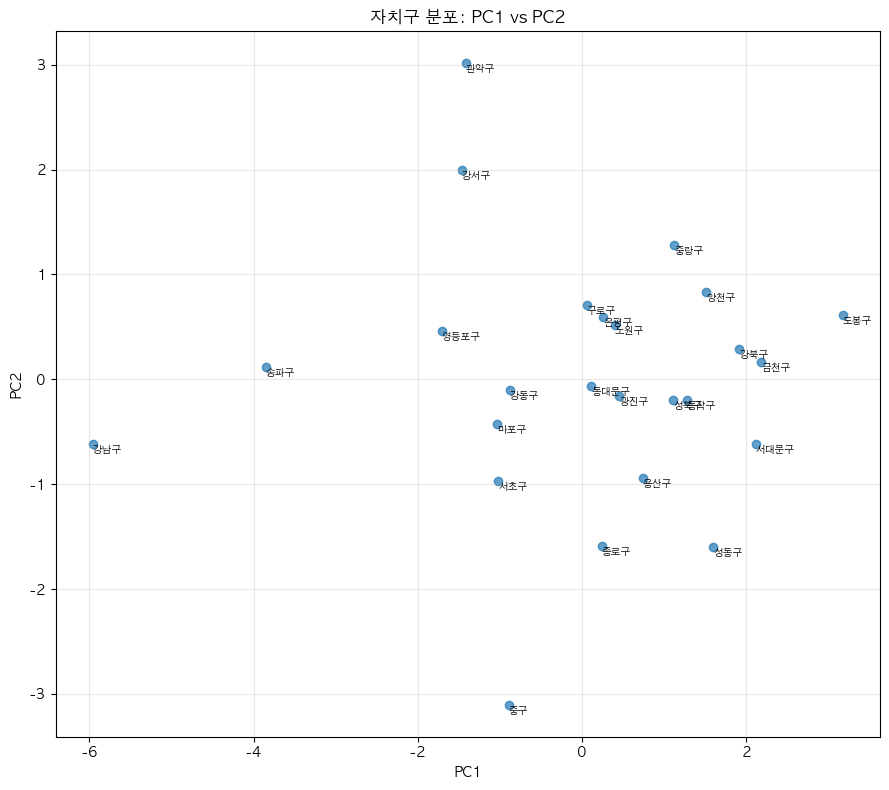


[PCA_자취적합지수 Top 10]
           PC1       PC2       PC3       PC4  PCA_자취적합지수  PCA_순위  1인가구수
자치구별                                                                   
도봉구   3.170664  0.614067  0.729514 -0.896693    2.009961       1  43347
금천구   2.176401  0.161972 -0.184808 -0.062044    1.281699       2  53858
강북구   1.914603  0.290417 -0.065485 -0.196255    1.160704       3  53705
양천구   1.506171  0.832353  0.846758 -1.034289    1.086940       4  47886
서대문구  2.116864 -0.619138 -0.854610  0.442366    1.033996       5  56770
중랑구   1.120741  1.278187  0.170804 -0.951408    0.881795       6  69149
성북구   1.104918 -0.199859  0.357699  0.986441    0.721837       7  70230
동작구   1.271249 -0.194050 -0.694538  0.314852    0.641092       8  75148
성동구   1.598718 -1.594624 -0.930102  0.054911    0.480630       9  48442
노원구   0.396212  0.515010  0.686295 -0.399241    0.397052      10  67182

[MCDM(PC기준 균등 가중치)]
평가기준  가중치  가중치(%)
 PC1 0.25    25.0
 PC2 0.25    25.0
 PC3 0.25    25.0
 PC4 0.25    25.0

[MC

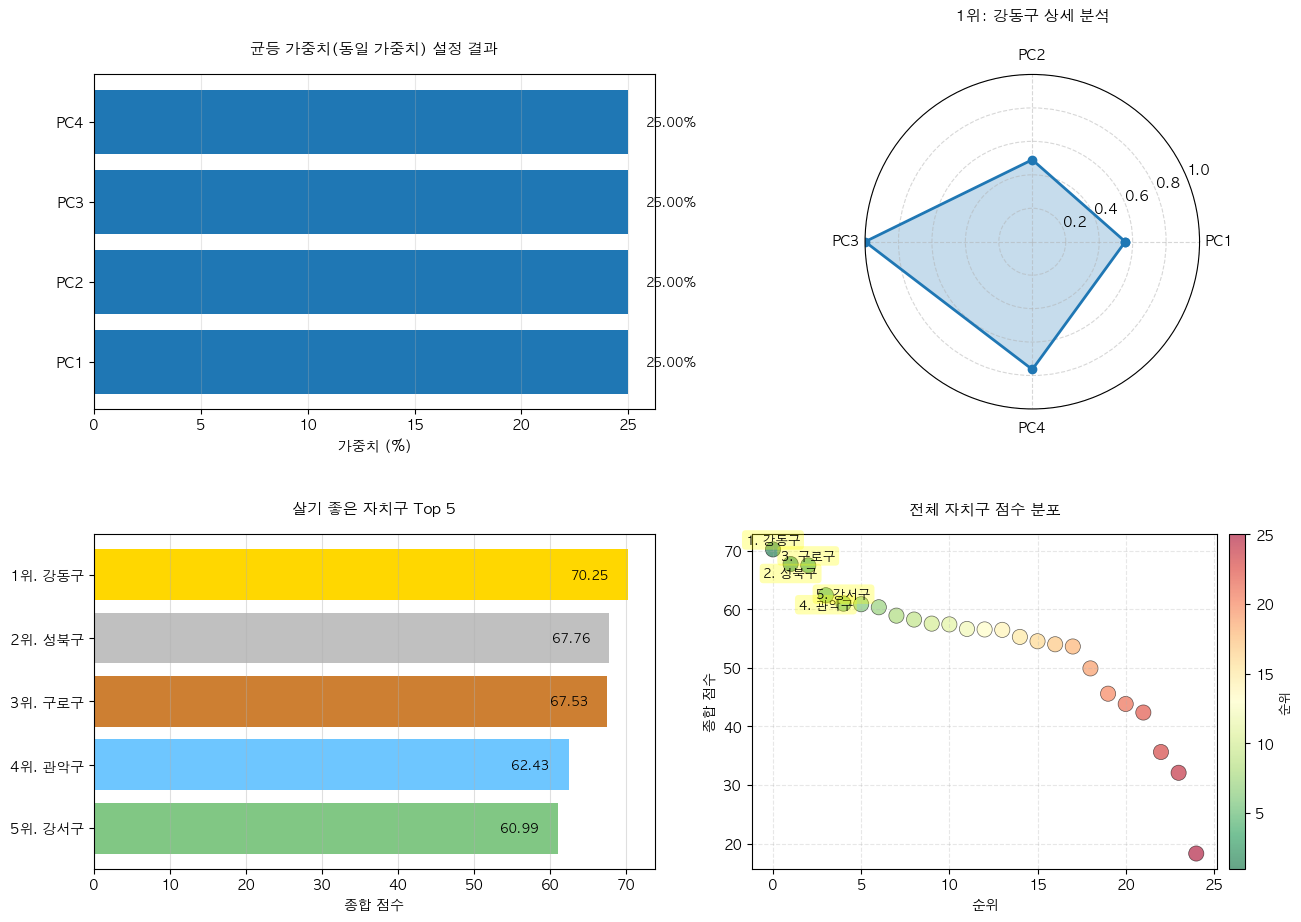

✅ 시각화 이미지 저장 완료: mcdm_uniform_results.png

✅ 엑셀 저장 완료: PCA_MCDM_통합결과_균등가중치.xlsx


In [3]:
# =========================================
# PCA + MCDM(Uniform Weight) 통합 분석 + 시각화 + 엑셀저장(스타일)
#  - 엔트로피 가중치 ❌
#  - PC들에 동일 가중치(균등) ✅
# =========================================

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from openpyxl import load_workbook
from openpyxl.styles import Font, PatternFill, Alignment, Border, Side


# -----------------------------------------
# 0) 한글 폰트 설정
# -----------------------------------------
font_candidates = ["NanumGothic", "Nanum Barun Gothic", "Malgun Gothic", "AppleGothic"]
available_fonts = [f.name for f in fm.fontManager.ttflist]
for font in font_candidates:
    if font in available_fonts:
        plt.rcParams["font.family"] = font
        break
plt.rcParams["axes.unicode_minus"] = False


# -----------------------------------------
# 1) 엑셀 저장 + 스타일 적용
# -----------------------------------------
def apply_excel_styles(file_path: str):
    wb = load_workbook(file_path)

    header_fill = PatternFill(start_color="4472C4", end_color="4472C4", fill_type="solid")
    header_font = Font(bold=True, color="FFFFFF", size=11)
    header_alignment = Alignment(horizontal="center", vertical="center")

    thin_border = Border(
        left=Side(style="thin"),
        right=Side(style="thin"),
        top=Side(style="thin"),
        bottom=Side(style="thin")
    )

    for sheet_name in wb.sheetnames:
        ws = wb[sheet_name]

        # header
        for cell in ws[1]:
            cell.fill = header_fill
            cell.font = header_font
            cell.alignment = header_alignment
            cell.border = thin_border

        # body
        for row in ws.iter_rows(min_row=2, max_row=ws.max_row, max_col=ws.max_column):
            for cell in row:
                cell.alignment = Alignment(horizontal="center", vertical="center")
                cell.border = thin_border

        # highlight
        if sheet_name == "Top5":
            gold_fill = PatternFill(start_color="FFD700", end_color="FFD700", fill_type="solid")
            if ws.max_row >= 2:
                for cell in ws[2]:
                    cell.fill = gold_fill

        if sheet_name == "Bottom5":
            red_fill = PatternFill(start_color="FFB6C1", end_color="FFB6C1", fill_type="solid")
            if ws.max_row >= 2:
                for cell in ws[ws.max_row]:
                    cell.fill = red_fill

        # column width
        for column in ws.columns:
            max_length = 0
            column_letter = column[0].column_letter
            for cell in column:
                try:
                    max_length = max(max_length, len(str(cell.value)))
                except Exception:
                    pass
            ws.column_dimensions[column_letter].width = min(max_length + 2, 20)

    wb.save(file_path)


def export_to_excel_with_style(results_df: pd.DataFrame,
                               weights: np.ndarray,
                               final_criteria: list[str],
                               district_col: str,
                               weight_df: pd.DataFrame,
                               output_file: str = "PCA_MCDM_통합결과_균등가중치.xlsx") -> str:
    with pd.ExcelWriter(output_file, engine="openpyxl") as writer:
        # 전체순위
        output_columns = [district_col] + final_criteria + ["종합점수", "순위"]
        display_df = results_df[output_columns].copy()

        # 0~1 -> 0~100 변환(보기 좋게)
        for c in final_criteria:
            display_df[c] = display_df[c] * 100

        display_df.to_excel(writer, sheet_name="전체순위", index=False)
        display_df.head(5).to_excel(writer, sheet_name="Top5", index=False)
        display_df.tail(5).to_excel(writer, sheet_name="Bottom5", index=False)

        # 가중치
        weight_df.to_excel(writer, sheet_name="가중치", index=False)

        # 통계요약
        stats_data = []
        for criterion in final_criteria + ["종합점수"]:
            if criterion in display_df.columns:
                stats_data.append({
                    "평가기준": criterion,
                    "평균": float(display_df[criterion].mean()),
                    "최댓값": float(display_df[criterion].max()),
                    "최솟값": float(display_df[criterion].min()),
                    "표준편차": float(display_df[criterion].std())
                })
        pd.DataFrame(stats_data).to_excel(writer, sheet_name="통계요약", index=False)

    apply_excel_styles(output_file)
    print(f"\n✅ 엑셀 저장 완료: {output_file}")
    return output_file


# -----------------------------------------
# 2) MCDM 시각화 (너 코드 스타일 유지)
# -----------------------------------------
def visualize_results(results_df: pd.DataFrame,
                      weights: np.ndarray,
                      criteria: list[str],
                      district_col: str,
                      out_png: str = "mcdm_uniform_results.png"):
    fig = plt.figure(figsize=(14, 10))

    # 1) 가중치 바차트
    ax1 = plt.subplot(2, 2, 1)
    weight_df = pd.DataFrame({"기준": criteria, "가중치": weights * 100})
    bars = ax1.barh(weight_df["기준"], weight_df["가중치"])
    ax1.set_xlabel("가중치 (%)", fontsize=10)
    ax1.set_title("균등 가중치(동일 가중치) 설정 결과", fontsize=11, fontweight="bold", pad=15)
    ax1.grid(axis="x", alpha=0.3)

    for bar in bars:
        w = bar.get_width()
        ax1.text(w + 0.8, bar.get_y() + bar.get_height()/2,
                 f"{w:.2f}%", ha="left", va="center", fontsize=9)

    # 2) Top5 바차트
    ax2 = plt.subplot(2, 2, 3)
    top5 = results_df.head(5)

    colors = ['#FFD700', '#C0C0C0', '#CD7F32', '#6EC6FF', '#81C784']
    bars2 = ax2.barh(range(len(top5)), top5["종합점수"].values, color=colors)

    ax2.set_yticks(range(len(top5)))
    ax2.set_yticklabels([f"{i+1}위. {name}" for i, name in enumerate(top5[district_col].values)], fontsize=10)
    ax2.set_xlabel("종합 점수", fontsize=10)
    ax2.set_title("살기 좋은 자치구 Top 5", fontsize=11, fontweight="bold", pad=15)
    ax2.invert_yaxis()
    ax2.grid(axis="x", alpha=0.4)

    for i, bar in enumerate(bars2):
        w = bar.get_width()
        ax2.text(w - 2.5, bar.get_y() + bar.get_height()/2,
                 f"{w:.2f}", ha="right", va="center",
                 fontsize=9, fontweight="bold", color="black")

    # 3) 레이더 차트 (1위)
    ax3 = plt.subplot(2, 2, 2, projection="polar")
    top1 = results_df.iloc[0]

    vals = [float(top1[c]) for c in criteria]
    angles = np.linspace(0, 2*np.pi, len(criteria), endpoint=False).tolist()
    vals += vals[:1]
    angles += angles[:1]

    ax3.plot(angles, vals, "o-", linewidth=2, markersize=6)
    ax3.fill(angles, vals, alpha=0.25)
    ax3.set_xticks(angles[:-1])
    ax3.set_xticklabels(criteria, fontsize=10)
    ax3.set_ylim(0, 1.0)
    ax3.set_title(f"1위: {top1[district_col]} 상세 분석", fontsize=11, fontweight="bold", pad=20)
    ax3.grid(True, linestyle="--", alpha=0.5)

    # 4) 전체 점수 분포
    ax4 = plt.subplot(2, 2, 4)
    scatter = ax4.scatter(range(len(results_df)),
                          results_df["종합점수"].values,
                          c=results_df["순위"].values,
                          cmap="RdYlGn_r",
                          s=120,
                          alpha=0.6,
                          edgecolors="black",
                          linewidths=0.5)
    ax4.set_xlabel("순위", fontsize=10)
    ax4.set_ylabel("종합 점수", fontsize=10)
    ax4.set_title("전체 자치구 점수 분포", fontsize=11, fontweight="bold", pad=15)
    ax4.grid(True, alpha=0.3, linestyle="--")

    for i in range(min(5, len(results_df))):
        x = i
        y = results_df.iloc[i]["종합점수"]
        name = results_df.iloc[i][district_col]
        y_offset = 2.5 if i % 2 == 0 else -2.5
        va = "bottom" if i % 2 == 0 else "top"
        ax4.annotate(f"{i+1}. {name}", (x, y),
                     xytext=(0, y_offset), textcoords="offset points",
                     ha="center", va=va, fontsize=9, fontweight="bold",
                     bbox=dict(boxstyle="round,pad=0.3", facecolor="yellow", alpha=0.3, edgecolor="none"))

    cbar = plt.colorbar(scatter, ax=ax4, pad=0.02)
    cbar.set_label("순위", fontsize=9)

    plt.tight_layout(pad=3.5)
    plt.savefig(out_png, dpi=300, bbox_inches="tight")
    plt.show()
    print(f"✅ 시각화 이미지 저장 완료: {out_png}")


# -----------------------------------------
# 3) 상관관계 버블 차트
# -----------------------------------------
def plot_corr_bubble(selected_clean: pd.DataFrame, label_map: dict):
    corr = selected_clean.corr()
    corr_plot = corr.rename(index=label_map, columns=label_map)

    plt.figure(figsize=(9, 8))
    ax = plt.gca()
    n = len(corr_plot.columns)

    for i in range(n):
        for j in range(i + 1):
            v = corr_plot.iloc[i, j]
            ax.scatter(i, j, s=abs(v) * 2300, c=v, cmap="RdBu_r", vmin=-1, vmax=1)
            ax.text(i, j, f"{v:.2f}", ha="center", va="center", fontsize=9)

    ax.set_xticks(range(n))
    ax.set_yticks(range(n))
    ax.set_xticklabels(corr_plot.columns, rotation=45, ha="right")
    ax.set_yticklabels(corr_plot.columns)

    ax.set_xticks(np.arange(-0.5, n, 1), minor=True)
    ax.set_yticks(np.arange(-0.5, n, 1), minor=True)
    ax.grid(which="minor", color="lightgray", linestyle="-", linewidth=0.8)
    ax.tick_params(which="minor", bottom=False, left=False)

    plt.title("서울시 1인 가구 관련 지표 간 상관관계", fontsize=14)
    sm = plt.cm.ScalarMappable(cmap="RdBu_r", norm=plt.Normalize(-1, 1))
    sm.set_array([])
    plt.colorbar(sm, ax=ax, fraction=0.046, pad=0.04, label="상관계수")

    plt.tight_layout()
    plt.show()


def plot_loadings_heatmap(loadings: pd.DataFrame, n_pc: int = 4, title: str = "성분분석표(Loadings) Heatmap"):
    L = loadings.iloc[:, :n_pc].copy()
    fig, ax = plt.subplots(figsize=(1.4*n_pc + 6, 0.6*len(L) + 2))
    im = ax.imshow(L.values, aspect="auto", cmap="RdBu_r", vmin=-1, vmax=1)

    ax.set_xticks(np.arange(L.shape[1]))
    ax.set_xticklabels(L.columns, fontsize=10)
    ax.set_yticks(np.arange(L.shape[0]))
    ax.set_yticklabels(L.index, fontsize=10)

    for i in range(L.shape[0]):
        for j in range(L.shape[1]):
            v = L.values[i, j]
            ax.text(j, i, f"{v:.2f}", ha="center", va="center", fontsize=9)

    ax.set_title(title, fontsize=12, fontweight="bold", pad=12)
    ax.grid(False)

    cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    cbar.set_label("Loading", fontsize=10)

    plt.tight_layout()
    plt.show()


def plot_loadings_bars(loadings: pd.DataFrame, n_pc: int = 4, top_k: int = None):
    L = loadings.iloc[:, :n_pc].copy()

    for pc in L.columns:
        s = L[pc].copy()
        if top_k is not None:
            s = s.reindex(s.abs().sort_values(ascending=False).index[:top_k])

        fig, ax = plt.subplots(figsize=(8, 0.45*len(s) + 2))
        bars = ax.barh(s.index, s.values)
        ax.axvline(0, linewidth=1)
        ax.set_title(f"{pc} 로딩(Loadings)", fontsize=12, fontweight="bold", pad=10)
        ax.set_xlabel("Loading", fontsize=10)
        ax.grid(axis="x", alpha=0.3)

        for b in bars:
            w = b.get_width()
            ax.text(w + (0.02 if w >= 0 else -0.02),
                    b.get_y() + b.get_height()/2,
                    f"{w:.2f}",
                    ha="left" if w >= 0 else "right",
                    va="center",
                    fontsize=9)

        plt.tight_layout()
        plt.show()


# -----------------------------------------
# 4) 메인 실행 (엔트로피 대신 균등가중치)
# -----------------------------------------
def main():
    # ========== (A) 데이터 로드 & 전처리 (다단헤더 안전) ==========
    file_path = "서울시 1인가구수 (1).xlsx"  # ✅ 필요시 경로 수정
    raw = pd.read_excel(file_path, sheet_name=0, header=None)

    # ✅ 헤더가 4행(인덱스 4)에 있는 형태 대응
    header = raw.iloc[4].astype(str).str.replace("\n", "", regex=False).str.strip()
    header.iloc[0] = "자치구별"

    data = raw.iloc[5:].copy()
    data.columns = header

    # ✅ 필요한 컬럼만 뽑고 표준 이름으로 변경
    # - 1인가구수: '총'
    # - 주거비용: '평당월세 평균'
    # - 범죄: '발생', '검거'
    # - 교통: '지하철'
    # - 인프라: '대규모점포'
    # - 의료시설: '총합'
    need_cols = ["자치구별", "총", "평당월세 평균", "발생", "검거", "지하철", "대규모점포", "총합"]
    missing = [c for c in need_cols if c not in data.columns]
    if missing:
        raise ValueError(f"필요 컬럼을 못 찾았습니다: {missing}\n현재 컬럼 일부: {list(data.columns)[:30]}")

    data = data[need_cols].copy()
    data = data.rename(columns={
        "총": "1인가구수",
        "평당월세 평균": "주거비용",
        "발생": "범죄_발생",
        "검거": "범죄_검거",
        "지하철": "교통",
        "대규모점포": "인프라",
        "총합": "의료시설"
    })

    data = data.set_index("자치구별")
    selected = data[["1인가구수", "주거비용", "범죄_발생", "범죄_검거", "교통", "인프라", "의료시설"]].apply(pd.to_numeric, errors="coerce")
    selected_clean = selected.dropna().copy()

    # 상관관계 그래프용 라벨
    label_map = {
        "1인가구수": "1인가구수",
        "인프라": "인프라",
        "주거비용": "주거비용",
        "교통": "교통",
        "의료시설": "의료시설",
        "범죄_발생": "범죄_발생",
        "범죄_검거": "범죄_검거"
    }
    plot_corr_bubble(selected_clean, label_map)

    # ========== (B) PCA ==========
    features = ["1인가구수", "주거비용", "범죄_발생", "범죄_검거", "교통", "인프라", "의료시설"]
    X = selected_clean[features].copy()

    # 방향 통일(클수록 좋음)
    X["주거비용"] *= -1
    X["범죄_발생"] *= -1

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    pca = PCA()
    X_pca = pca.fit_transform(X_scaled)

    explained = pca.explained_variance_ratio_
    cumulative = np.cumsum(explained)

    explained_df = pd.DataFrame({
        "PC": [f"PC{i+1}" for i in range(len(explained))],
        "설명분산비율": explained,
        "누적설명분산": cumulative
    })
    print("\n[설명분산/누적설명분산]")
    print(explained_df.to_string(index=False))

    loadings = pd.DataFrame(
        pca.components_.T,
        index=features,
        columns=[f"PC{i+1}" for i in range(len(features))]
    )
    print("\n[성분분석표(loadings)]")
    print(loadings)

    # scree plot
    plt.figure(figsize=(7, 4))
    plt.plot(range(1, len(explained) + 1), explained, marker="o")
    plt.xticks(range(1, len(explained) + 1))
    plt.xlabel("PC")
    plt.ylabel("Explained Variance Ratio")
    plt.title("Scree Plot")
    plt.tight_layout()
    plt.show()

    # cumulative
    plt.figure(figsize=(7, 4))
    plt.plot(range(1, len(cumulative) + 1), cumulative, marker="o")
    plt.xticks(range(1, len(cumulative) + 1))
    plt.xlabel("Principal Component")
    plt.ylabel("Cumulative Explained Variance")
    plt.title("Cumulative Explained Variance")
    plt.axhline(0.7, linestyle="--")
    plt.axhline(0.8, linestyle="--")
    plt.tight_layout()
    plt.show()

    # ========== (C) PC 점수 생성 ==========
    n_pc = 4
    scores = pd.DataFrame(
        X_pca[:, :n_pc],
        index=selected_clean.index,
        columns=[f"PC{i+1}" for i in range(n_pc)]
    )
    scores["1인가구수"] = selected_clean["1인가구수"]

    print("loading 시각화")
    plot_loadings_heatmap(loadings, n_pc=n_pc, title="성분분석표(Loadings) Heatmap (PC1~PC4)")
    plot_loadings_bars(loadings, n_pc=n_pc, top_k=None)

    # PC1 vs PC2 산점도
    if n_pc >= 2:
        plt.figure(figsize=(9, 8))
        plt.scatter(scores["PC1"], scores["PC2"], alpha=0.7)
        for gu in scores.index:
            plt.text(scores.loc[gu, "PC1"], scores.loc[gu, "PC2"], gu, fontsize=7, ha="left", va="top")
        plt.xlabel("PC1")
        plt.ylabel("PC2")
        plt.title("자치구 분포: PC1 vs PC2")
        plt.grid(alpha=0.3)
        plt.tight_layout()
        plt.show()

    # ========== (D) PCA 가중합 지수 (설명분산 기반) ==========
    pca_weights = explained[:n_pc]
    pca_weights = pca_weights / pca_weights.sum()

    scores["PCA_자취적합지수"] = 0.0
    for i in range(n_pc):
        scores["PCA_자취적합지수"] += pca_weights[i] * scores[f"PC{i+1}"]
    scores["PCA_순위"] = scores["PCA_자취적합지수"].rank(ascending=False, method="min").astype(int)

    print("\n[PCA_자취적합지수 Top 10]")
    print(scores.sort_values("PCA_순위").head(10)[[f"PC{i+1}" for i in range(n_pc)] + ["PCA_자취적합지수", "PCA_순위", "1인가구수"]])

    # ========== (E) PCA → MCDM(균등 가중치) 연결 ==========
    pc_cols = [f"PC{i+1}" for i in range(n_pc)]
    pc_df = scores[pc_cols].copy()

    # 0~1 정규화
    den = (pc_df.max() - pc_df.min()).replace(0, np.nan)
    pc_norm = (pc_df - pc_df.min()) / den
    pc_norm = pc_norm.fillna(0.5)

    # ✅✅✅ 여기 핵심: 엔트로피 대신 "균등 가중치"
    mcdm_weights = np.ones(len(pc_cols)) / len(pc_cols)

    # 종합점수/순위
    scores["종합점수"] = np.dot(pc_norm.values, mcdm_weights) * 100
    scores["순위"] = scores["종합점수"].rank(ascending=False, method="min").astype(int)

    district_col = "자치구별"
    results_df = scores.reset_index().rename(columns={scores.reset_index().columns[0]: district_col}).sort_values("순위")

    final_criteria = pc_cols

    weight_df = pd.DataFrame({
        "평가기준": final_criteria,
        "가중치": mcdm_weights,
        "가중치(%)": mcdm_weights * 100
    })

    print("\n[MCDM(PC기준 균등 가중치)]")
    print(weight_df.to_string(index=False))

    print("\n[MCDM(PC기준 균등 가중치) Top 10]")
    print(results_df.head(10)[[district_col] + final_criteria + ["종합점수", "순위"]])

    # 상관/순위 일치도
    corr_pca = scores["PCA_자취적합지수"].corr(scores["1인가구수"])
    corr_mcdm = scores["종합점수"].corr(scores["1인가구수"])
    spearman_rank = scores["PCA_순위"].corr(scores["순위"], method="spearman")
    print(f"\n[상관계수] PCA_자취적합지수 vs 1인가구수: {corr_pca:.4f}")
    print(f"[상관계수] MCDM(균등) 종합점수 vs 1인가구수: {corr_mcdm:.4f}")
    print(f"[순위 일치도(Spearman)] PCA_순위 vs MCDM(균등)_순위: {spearman_rank:.4f}")

    # ========== (F) 시각화 ==========
    norm_df = pc_norm.copy()
    norm_df["종합점수"] = scores["종합점수"]
    norm_df["순위"] = scores["순위"]
    norm_df = norm_df.reset_index().rename(columns={norm_df.reset_index().columns[0]: district_col}).sort_values("순위")

    visualize_results(
        results_df=norm_df,
        weights=mcdm_weights,
        criteria=final_criteria,
        district_col=district_col,
        out_png="mcdm_uniform_results.png"
    )

    # ========== (G) 엑셀 저장 ==========
    export_to_excel_with_style(
        results_df=norm_df,
        weights=mcdm_weights,
        final_criteria=final_criteria,
        district_col=district_col,
        weight_df=weight_df,
        output_file="PCA_MCDM_통합결과_균등가중치.xlsx"
    )

    return results_df, weight_df


if __name__ == "__main__":
    results_df, weight_df = main()
